In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv3D, ConvLSTM2D, UpSampling2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

In [2]:
Y_train = np.load("/opt/datos/dataset/gfs/Y.npy")
print(Y_train.shape)

(19288, 137, 157)


In [3]:
train = Y_train.reshape(2411,8,137,157,1)
Y_train = None
print(train.shape)

(2411, 8, 137, 157, 1)


In [4]:
x_train = train[0:1800, 0:4, 0:128, 0:144, :]
y_train = train[0:1800, 4:8, 0:128, 0:144, :]
x_val   = train[1800:2160, 0:4, 0:128, 0:144, :]
y_val   = train[1800:2160, 4:8, 0:128, 0:144, :]
x_test  = train[2160:, 0:4, 0:128, 0:144, :]
y_test  = train[2160:, 4:8, 0:128, 0:144, :]

In [ ]:
# si dividimos en val al momento de ent
x_train = train[0:2160, 0:4, 0:128, 0:144, :]
y_train = train[0:2160, 4:8, 0:128, 0:144, :]
x_test  = train[2160:, 0:4, 0:128, 0:144, :]
y_test  = train[2160:, 4:8, 0:128, 0:144, :]

In [5]:
x_train2 = np.concatenate((np.zeros((1800,1,128,144,1)), train[:1800, 4:7, 0:128, 0:144,:]), axis=1)
#x_train2 = np.concatenate((np.zeros((2160,1,128,144,1)), train[:2160, 4:7, 0:128, 0:144,:]), axis=1)

In [6]:
x_val2 = np.concatenate((np.zeros((360,1,128,144,1)), train[1800:2160, 4:7, 0:128, 0:144,:]), axis=1)

In [7]:
print(x_train.shape)
print(x_train2.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1800, 4, 128, 144, 1)
(1800, 4, 128, 144, 1)
(1800, 4, 128, 144, 1)
(360, 4, 128, 144, 1)
(360, 4, 128, 144, 1)
(251, 4, 128, 144, 1)
(251, 4, 128, 144, 1)


In [8]:
"""
3-layer stacked ConvLSTM2D Encoder-Decoder
"""

def lstm(n_filter, filter_size):
    # define training encoder
    encoder_inputs = Input(shape=(None, 128, 144, 1))
    encoder_1 = ConvLSTM2D(filters = n_filter, kernel_size=filter_size, padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    encoder_2 = ConvLSTM2D(filters = 32, kernel_size=filter_size, padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    encoder_3 = ConvLSTM2D(filters = 32, kernel_size=filter_size, padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    encoder_outputs_1, encoder_state_h_1, encoder_state_c_1 = encoder_1(encoder_inputs)
    encoder_outputs_2, encoder_state_h_2, encoder_state_c_2 = encoder_2(encoder_outputs_1)
    encoder_outputs_3, encoder_state_h_3, encoder_state_c_3 = encoder_3(encoder_outputs_2)
    # define training decoder
    decoder_inputs = Input(shape=(None, 128, 144, 1))
    decoder_1 = ConvLSTM2D(filters=n_filter, kernel_size=filter_size, padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    decoder_2 = ConvLSTM2D(filters=32, kernel_size=filter_size, padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    decoder_3 = ConvLSTM2D(filters=32, kernel_size=filter_size, padding='same', return_sequences=True, return_state=True,
                           kernel_regularizer=l2(0.0005), recurrent_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    decoder_outputs_1, _, _ = decoder_1([decoder_inputs, encoder_state_h_1, encoder_state_c_1])
    decoder_outputs_2, _, _ = decoder_2([decoder_outputs_1, encoder_state_h_2, encoder_state_c_2])
    decoder_outputs_3, _, _ = decoder_3([decoder_outputs_2, encoder_state_h_3, encoder_state_c_3])
    decoder_conv3d = Conv3D(filters=1, kernel_size=(1,1,32), padding='same', data_format='channels_last',
                            kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005))
    decoder_outputs = decoder_conv3d(decoder_outputs_3)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #print(model.summary(line_length=250))
    
    # define inference encoder
    encoder_model = Model(encoder_inputs, 
                          [encoder_state_h_1, encoder_state_c_1, encoder_state_h_2, encoder_state_c_2, encoder_state_h_3, encoder_state_c_3])
    
    # define inference decoder
    decoder_state_input_h_1 = Input(shape=(128, 144,n_filter))
    decoder_state_input_c_1 = Input(shape=(128, 144,n_filter))
    decoder_state_input_h_2 = Input(shape=(128, 144,32))
    decoder_state_input_c_2 = Input(shape=(128, 144,32))
    decoder_state_input_h_3 = Input(shape=(128, 144,32))
    decoder_state_input_c_3 = Input(shape=(128, 144,32))
    decoder_output_1, decoder_state_h_1_new, decoder_state_c_1_new = decoder_1([decoder_inputs, decoder_state_input_h_1, decoder_state_input_c_1])
    decoder_output_2, decoder_state_h_2_new, decoder_state_c_2_new = decoder_2([decoder_output_1, decoder_state_input_h_2, decoder_state_input_c_2])
    decoder_output_3, decoder_state_h_3_new, decoder_state_c_3_new = decoder_3([decoder_output_2, decoder_state_input_h_3, decoder_state_input_c_3])
    decoder_output = decoder_conv3d(decoder_output_3)
    decoder_model = Model([decoder_inputs , decoder_state_input_h_1 , decoder_state_input_c_1, decoder_state_input_h_2 , decoder_state_input_c_2, 
                           decoder_state_input_h_3 , decoder_state_input_c_3],
                          [decoder_output, decoder_state_h_1_new, decoder_state_c_1_new, decoder_state_h_2_new, decoder_state_c_2_new, 
                           decoder_state_h_3_new, decoder_state_c_3_new])
    
    return model, encoder_model, decoder_model

In [9]:
model, encoder, decoder = lstm(n_filter=64, filter_size=5)

In [10]:
print(model.summary(line_length=135))

Model: "model"
_______________________________________________________________________________________________________________________________________
Layer (type)                                Output Shape                  Param #         Connected to                                 
input_1 (InputLayer)                        [(None, None, 128, 144, 1)]   0                                                            
_______________________________________________________________________________________________________________________________________
input_2 (InputLayer)                        [(None, None, 128, 144, 1)]   0                                                            
_______________________________________________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)                   [(None, None, 128, 144, 64),  416256          input_1[0][0]                                
_________________________________

In [11]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [12]:
history = model.fit([x_train, x_train2], y_train, batch_size=4, validation_data=([x_val, x_val2],y_val), epochs=10)

Epoch 1/10
450/450 [==============================] - 1575s 3s/step - loss: 2.4902 - mae: 0.4417 - val_loss: 1.1597 - val_mae: 0.3142
Epoch 2/10
450/450 [==============================] - 1561s 3s/step - loss: 1.8431 - mae: 0.3984 - val_loss: 1.0981 - val_mae: 0.3632
Epoch 3/10
450/450 [==============================] - 1561s 3s/step - loss: 1.7753 - mae: 0.3943 - val_loss: 1.0479 - val_mae: 0.3178
Epoch 4/10
450/450 [==============================] - 1561s 3s/step - loss: 1.7040 - mae: 0.3826 - val_loss: 1.0273 - val_mae: 0.3113
Epoch 5/10
450/450 [==============================] - 1561s 3s/step - loss: 1.5916 - mae: 0.3719 - val_loss: 1.0473 - val_mae: 0.3320
Epoch 6/10
450/450 [==============================] - 1561s 3s/step - loss: 1.6596 - mae: 0.3792 - val_loss: 1.0308 - val_mae: 0.3188
Epoch 7/10
450/450 [==============================] - 1561s 3s/step - loss: 1.6975 - mae: 0.3807 - val_loss: 1.0382 - val_mae: 0.3204
Epoch 8/10
450/450 [==============================] - 1561s 3s

In [13]:
with open('lstm-02', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [14]:
history = pickle.load( open( "lstm-02", "rb" ) )

~ lstm ~
val_loss: 1.0346293449401855
loss: 1.6088628768920898


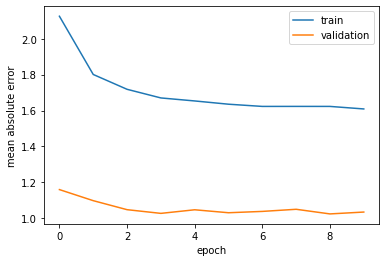

In [15]:
print("~ lstm ~")
print(f"val_loss: {history['val_loss'][-1]}")
print(f"loss: {history['loss'][-1]}")
#print(history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
#model.save('lstm-02.h5')
encoder.save('encoder-10e.h5')
decoder.save('decoder-10e.')

## Prediccion

In [17]:
# generate target given source sequence
def predict_sequence_3(infenc, infdec, source, n_steps):
    # encode
    state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3 = infenc.predict(source)  # source_dim = ()
#decoder_input = source[:,-1,:,:,:].reshape((1,1,64,64,1))
    decoder_input = np.repeat(0,128*144).reshape((1,1,128,144,1))
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h_1, c_1, h_2, c_2, h_3, c_3 = infdec.predict([decoder_input, state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3])
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state_h_1, state_c_1, state_h_2, state_c_2, state_h_3, state_c_3 = h_1, c_1, h_2, c_2, h_3, c_3
        # update target sequence
        decoder_input = yhat
    return np.array(output)

In [89]:
Y = np.load("/opt/datos/dataset/gfs/Y.npy")
data = Y.reshape(2411,8,137,157,1)
x_test  = data[2160:, 0:4, 0:128, 0:144, :]
y_test  = data[2160:, 4:8, 0:128, 0:144, :]

n = 98
pred3 = predict_sequence_3(encoder, decoder, x_test[np.newaxis,n,:,:,:,:], 4)

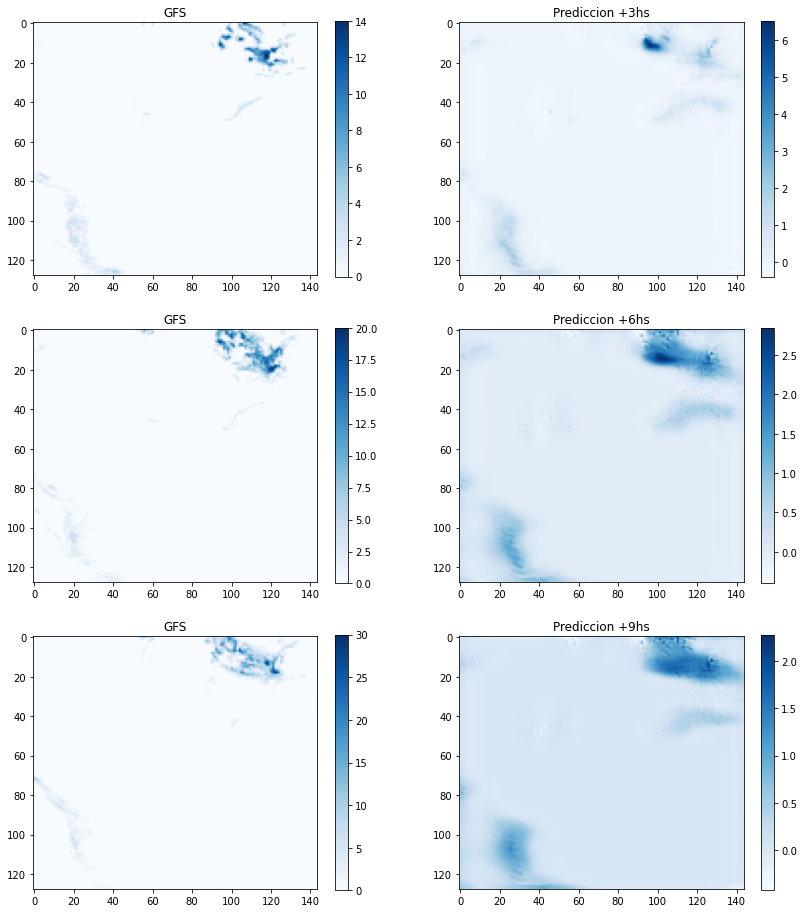

In [90]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 16)
axs[0][0] = plt.subplot(321), plt.imshow(y_test[n,0,:,:,:], cmap='Blues'), plt.colorbar(), plt.title('GFS')
axs[1][0] = plt.subplot(323), plt.imshow(y_test[n,1,:,:,:], cmap='Blues'), plt.colorbar(), plt.title('GFS')
axs[2][0] = plt.subplot(325), plt.imshow(y_test[n,2,:,:,:], cmap='Blues'), plt.colorbar(), plt.title('GFS')
axs[0][1] = plt.subplot(322), plt.imshow(pred3[0], cmap='Blues'), plt.colorbar(), plt.title('Prediccion +3hs')
axs[1][1] = plt.subplot(324), plt.imshow(pred3[1], cmap='Blues'), plt.colorbar(), plt.title('Prediccion +6hs')
axs[2][1] = plt.subplot(326), plt.imshow(pred3[2], cmap='Blues'), plt.colorbar(), plt.title('Prediccion +9hs')

plt.show()